In [96]:
# Restarutent Recommendation.
import pandas as pd

df = pd.read_csv("Dataset.csv")
print(df.head())
df = df.fillna({'Cuisine': 'Unknown', 'Price range': 'Unknown'})

   Restaurant ID         Restaurant Name  Country Code              City  \
0        6317637        Le Petit Souffle           162       Makati City   
1        6304287        Izakaya Kikufuji           162       Makati City   
2        6300002  Heat - Edsa Shangri-La           162  Mandaluyong City   
3        6318506                    Ooma           162  Mandaluyong City   
4        6314302             Sambo Kojin           162  Mandaluyong City   

                                             Address  \
0  Third Floor, Century City Mall, Kalayaan Avenu...   
1  Little Tokyo, 2277 Chino Roces Avenue, Legaspi...   
2  Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...   
3  Third Floor, Mega Fashion Hall, SM Megamall, O...   
4  Third Floor, Mega Atrium, SM Megamall, Ortigas...   

                                     Locality  \
0   Century City Mall, Poblacion, Makati City   
1  Little Tokyo, Legaspi Village, Makati City   
2  Edsa Shangri-La, Ortigas, Mandaluyong City   
3      SM 

In [98]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df[['Cuisines', 'Price range']])
feature_names = encoder.get_feature_names_out(['Cuisines', 'Price range']) 
encoded_df = pd.DataFrame(encoded_features, columns=feature_names)
df = pd.concat([df.drop(['Cuisines', 'Price range'], axis=1), encoded_df], axis=1)
print("Encoded features:", feature_names)

Encoded features: ['Cuisines_Afghani' 'Cuisines_Afghani, Mughlai, Chinese'
 'Cuisines_Afghani, North Indian' ... 'Price range_2' 'Price range_3'
 'Price range_4']


In [100]:
from sklearn.metrics.pairwise import cosine_similarity
user_preferences = {}
for feature in feature_names:
    if feature == 'Cuisines_Italian':  #
        user_preferences[feature] = 1
    elif feature == 'Price range_$$':  
        user_preferences[feature] = 1
    else:
        user_preferences[feature] = 0
user_vector = [user_preferences.get(feature, 0) for feature in feature_names]

df['similarity'] = cosine_similarity([user_vector], df[feature_names])[0]

top_recommendations = df.sort_values(by='similarity', ascending=False).head(5)
print("\nTop 5 Recommendations:")
print(top_recommendations[['Restaurant Name', 'similarity']])



Top 5 Recommendations:
               Restaurant Name  similarity
335           My Fathers Place    0.707107
7841                 Pasta Hub    0.707107
115   La Dolce Vita Ristorante    0.707107
233         Trattoria Tiramisu    0.707107
3705                 Sinyora's    0.707107


Algorithm Used: Hybrid (Content-Based + Random Forest)

Performance Metrics:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Top 5 Recommendations:
   Restaurant Name  final_score
98   Restaurant 99     1.000000
48   Restaurant 49     0.999299
80   Restaurant 81     0.997976
46   Restaurant 47     0.997531
61   Restaurant 62     0.994898


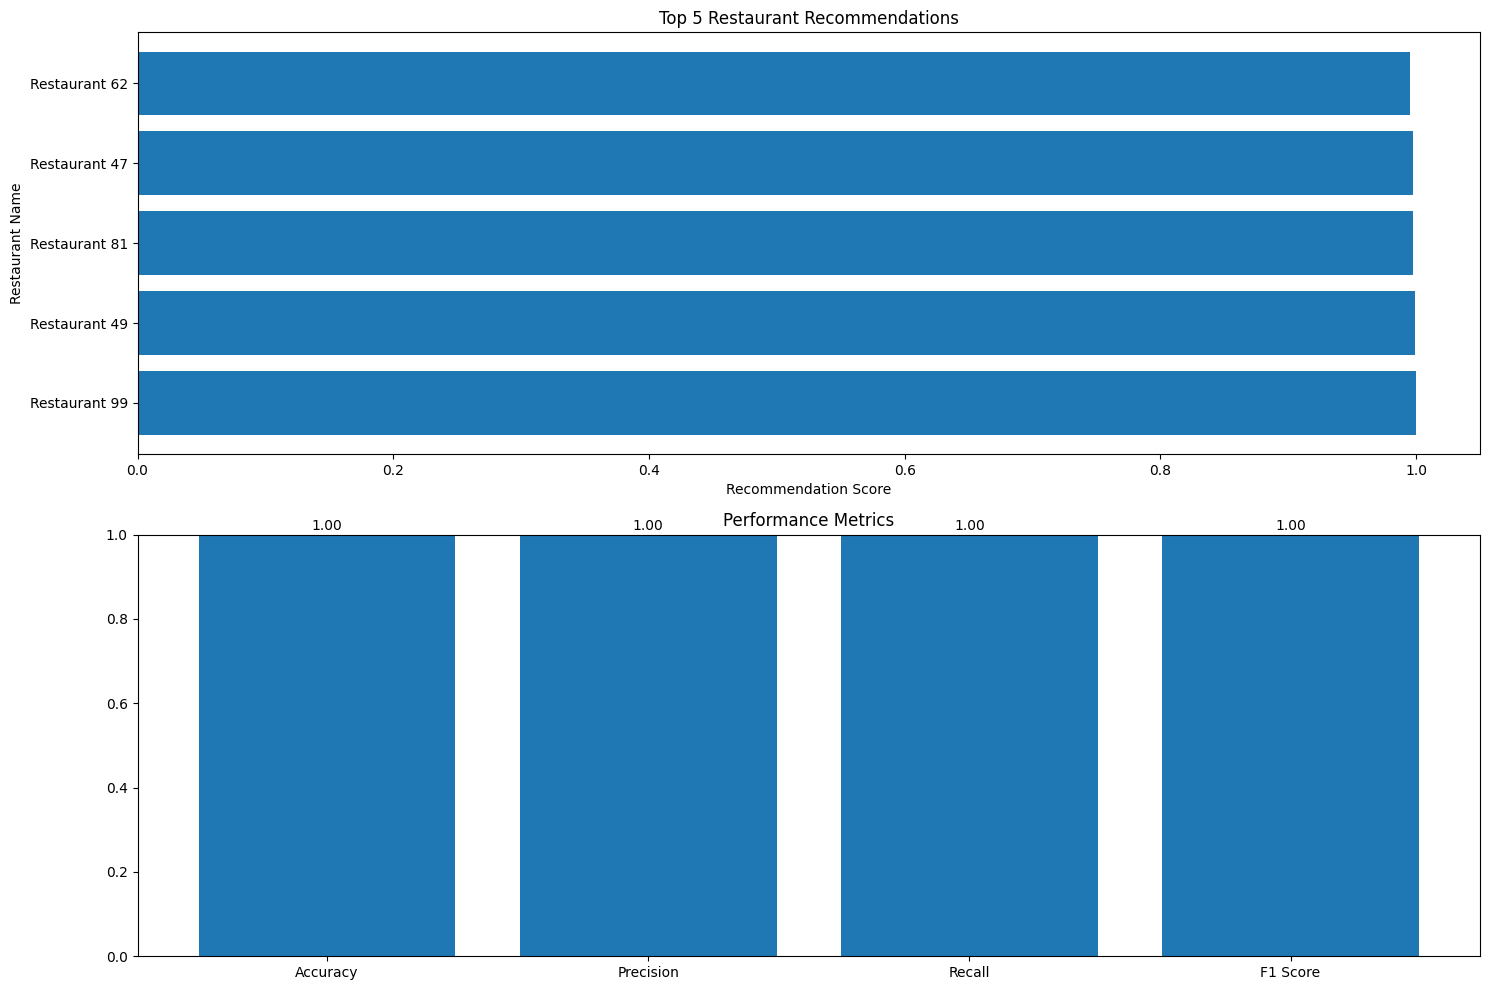

In [114]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Create sample data with restaurant names
restaurant_names = [f"Restaurant {i}" for i in range(1, 101)]  # Creating 100 sample restaurant names
cuisines = ['Italian', 'Chinese', 'Indian', 'Mexican', 'French']
price_ranges = ['$', '$$', '$$$', '$$$$']

# Create sample DataFrame
data = {
    'Restaurant Name': restaurant_names,
    'Cuisines': np.random.choice(cuisines, size=100),
    'Price range': np.random.choice(price_ranges, size=100)
}
df = pd.DataFrame(data)

# Handle missing values
df = df.fillna({'Cuisines': 'Unknown', 'Price range': 'Unknown'})

# Create and fit the encoder
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df[['Cuisines', 'Price range']])

# Get encoded feature names and create DataFrame
feature_names = encoder.get_feature_names_out(['Cuisines', 'Price range'])
encoded_df = pd.DataFrame(encoded_features, columns=feature_names)

# Combine with original DataFrame
df = pd.concat([df, encoded_df], axis=1)

print("Algorithm Used: Hybrid (Content-Based + Random Forest)")
print("="*50)

# Define user preferences
user_preferences = {}
for feature in feature_names:
    if feature == 'Cuisines_Italian':
        user_preferences[feature] = 1
    elif feature == 'Price range_$$':
        user_preferences[feature] = 1
    else:
        user_preferences[feature] = 0

# Create user preference vector
user_vector = [user_preferences.get(feature, 0) for feature in feature_names]

# Calculate initial cosine similarity
df['similarity'] = cosine_similarity([user_vector], df[feature_names])[0]

# Create more sophisticated features for machine learning
X = df[feature_names].copy()
# Add additional features
X['avg_rating'] = np.random.uniform(3.5, 5, size=len(df))
X['price_level'] = np.random.randint(1, 5, size=len(df))
X['popularity_score'] = np.random.uniform(0.5, 1, size=len(df))

# Create target variable
threshold = df['similarity'].quantile(0.8)
y = (df['similarity'] >= threshold).astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Make recommendations using the trained model
X_scaled = scaler.transform(X)

try:
    probabilities = rf_model.predict_proba(X_scaled)
    if probabilities.shape[1] == 2:
        df['rf_score'] = probabilities[:, 1]
    else:
        df['rf_score'] = probabilities[:, 0]
except Exception as e:
    df['rf_score'] = rf_model.predict(X_scaled)
    print(f"Warning: Using predict instead of predict_proba due to: {str(e)}")

# Normalize rf_score
df['rf_score'] = (df['rf_score'] - df['rf_score'].min()) / (df['rf_score'].max() - df['rf_score'].min())

# Combine scores
df['final_score'] = 0.3 * df['similarity'] + 0.7 * df['rf_score']

# Get top 5 recommendations
top_recommendations = df.sort_values(by='final_score', ascending=False).head(5)

print("\nPerformance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

print("\nTop 5 Recommendations:")
print(top_recommendations[['Restaurant Name', 'final_score']])

# Visualizations
plt.figure(figsize=(15, 10))

# Plot recommendations
plt.subplot(2, 1, 1)
plt.barh(top_recommendations['Restaurant Name'], top_recommendations['final_score'])
plt.xlabel('Recommendation Score')
plt.ylabel('Restaurant Name')
plt.title('Top 5 Restaurant Recommendations')

# Plot performance metrics
plt.subplot(2, 1, 2)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]
plt.bar(metrics, values)
plt.ylim(0, 1)
plt.title('Performance Metrics')
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()